<a href="https://colab.research.google.com/github/Intelligent-Systems-Phystech/2022-Project-93-2/blob/master/code/mean_std_classification_CASM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, auc, average_precision_score, \
                            make_scorer, precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score   
from collections import Counter
from google.colab import drive

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, auc, average_precision_score, \
                            make_scorer, precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score   
from collections import Counter
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/My Drive/Skoltech Floods/'
import os
import sys
sys.path.append(dir_path)

Mounted at /content/drive


In [ ]:
ex_dates = pd.read_table(dir_path + 'exday_99per_DJF_CASM_1980_2019.txt', delim_whitespace=True, names=('day_of_seq', 'year', 'month', 'day'))
nex_dates = pd.read_table(dir_path + 'nexday_99per_DJF_CASM_1980_2019.txt', delim_whitespace=True, names=('day_of_seq', 'year', 'month', 'day'))
ex_dates.insert(0, 'ex', pd.Series([1]*len(ex_dates)))
nex_dates.insert(0, 'ex', pd.Series([0]*len(nex_dates)))

features = ['h500', 'ivt', 'qv2m', 'slp', 'tpw', 'uqv', 'vqv', 'w500']
mean_vals = dict()

for feature in features:
    ex_X = pd.read_table(dir_path + f'ERA5/CASM/ERA5_DJF_CASM_99per_ex_n{feature}_1980_2019.txt', delim_whitespace=True, header = None)
    nex_X = pd.read_table(dir_path + f'ERA5/CASM/ERA5_DJF_CASM_99per_nex_n{feature}_1980_2019.txt', delim_whitespace=True, header = None)
    ex = pd.concat([ex_dates, ex_X], axis = 1)
    nex = pd.concat([nex_dates, nex_X], axis = 1)
    X_mean = pd.concat([ex, nex]).sort_values('day_of_seq').reset_index(drop=True)
    mean = X_mean.iloc[:,5:].values.mean(axis=1)
    mean_vals[feature] = mean

In [ ]:
ex_dates = pd.read_table(dir_path + 'exday_99per_DJF_CASM_1980_2019.txt', delim_whitespace=True, names=('day_of_seq', 'year', 'month', 'day'))
nex_dates = pd.read_table(dir_path + 'nexday_99per_DJF_CASM_1980_2019.txt', delim_whitespace=True, names=('day_of_seq', 'year', 'month', 'day'))
ex_dates.insert(0, 'ex', pd.Series([1]*len(ex_dates)))
nex_dates.insert(0, 'ex', pd.Series([0]*len(nex_dates)))

features = ['h500', 'ivt', 'qv2m', 'slp', 'tpw', 'uqv', 'vqv', 'w500']
std_vals = dict()

for feature in features:
    ex_X = pd.read_table(dir_path + f'ERA5/CASM/ERA5_DJF_CASM_99per_ex_n{feature}_1980_2019.txt', delim_whitespace=True, header = None)
    nex_X = pd.read_table(dir_path + f'ERA5/CASM/ERA5_DJF_CASM_99per_nex_n{feature}_1980_2019.txt', delim_whitespace=True, header = None)
    ex = pd.concat([ex_dates, ex_X], axis = 1)
    nex = pd.concat([nex_dates, nex_X], axis = 1)
    X_std = pd.concat([ex, nex]).sort_values('day_of_seq').reset_index(drop=True)
    std = X_std.iloc[:,5:].values.std(axis=1)
    std_vals[feature] = std

In [ ]:
X_mean['date'] = pd.to_datetime(X_mean[['year', 'month', 'day']])
df_mean = pd.DataFrame.from_dict(mean_vals)
df_mean['date'] = X_mean.date
df_mean.set_index('date', inplace = True, drop = True)
df_mean['ex'] = X_mean['ex'].values
df_mean.columns = ['h500_m', 'ivt_m', 'qv2m_m', 'slp_m', 'tpw_m', 'uqv_m', 'vqv_m', 'w500_m', 'ex']
df_mean.drop(columns = 'ex', inplace = True)

X_std['date'] = pd.to_datetime(X_std[['year', 'month', 'day']])
df_std = pd.DataFrame.from_dict(std_vals)
df_std['date'] = X_std.date
df_std.set_index('date', inplace = True, drop = True)
df_std['ex'] = X_std['ex'].values
df_std.columns = ['h500_std', 'ivt_std', 'qv2m_std', 'slp_std', 'tpw_std', 'uqv_std', 'vqv_std', 'w500_std', 'ex']

df = pd.concat([df_mean, df_std], axis = 1)

In [ ]:
from datetime import datetime

In [ ]:
df = df.reset_index()
df["day"] = df["date"].dt.dayofyear

In [ ]:
df

,date,h500_m,ivt_m,qv2m_m,slp_m,tpw_m,uqv_m,vqv_m,w500_m,h500_std,ivt_std,qv2m_std,slp_std,tpw_std,uqv_std,vqv_std,w500_std,ex,day,day_of_year
0,1980-01-01,0.101096,-0.190439,0.411886,-0.273224,0.303355,-0.163311,0.322961,-0.190548,0.530999,0.908322,0.906029,0.673107,0.849400,0.569867,1.079062,0.965381,0,1,32
1,1980-01-02,-0.077368,-0.128947,0.317478,-0.274342,0.250636,-0.104342,0.238004,-0.172237,0.676455,0.973508,0.926271,0.794021,0.929831,0.832833,1.105084,1.067417,0,2,33
2,1980-01-03,-0.333794,-0.330526,-0.016974,-0.325768,0.018004,-0.087368,0.013048,-0.151075,0.740520,0.856347,0.968628,0.800628,0.971815,0.811637,1.060485,1.022756,0,3,34
3,1980-01-04,-0.490461,-0.315219,-0.333487,-0.375833,-0.181184,-0.119781,-0.086184,-0.056316,0.895034,0.905010,0.934050,1.134577,1.037330,0.905180,1.155132,1.221864,0,4,35
4,1980-01-05,-0.530000,-0.075943,-0.423838,-0.501952,-0.127149,0.031535,0.107346,-0.132105,1.308361,1.063673,0.933331,1.499013,1.091915,1.252556,1.295984,1.303256,0,5,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,2019-12-27,-0.175351,-0.014452,0.167785,-0.391974,0.374825,0.219232,0.174035,-0.075000,0.673514,0.844738,0.860278,0.595738,0.944596,0.826753,0.992366,1.061812,0,361,26
3606,2019-12-28,-0.092259,0.247281,0.184232,-0.134211,0.361140,0.244408,0.149496,0.022939,0.793587,1.026481,0.775458,0.647114,0.881771,0.928708,1.150588,1.106486,0,362,27
3607,2019-12-29,0.118947,0.122281,0.104649,0.306382,0.121842,0.032127,-0.331382,0.303882,0.792444,0.894909,0.720232,0.623433,0.810617,1.057763,0.772130,0.787905,0,363,28
3608,2019-12-30,0.397171,0.292785,0.161206,0.354846,0.254408,0.188180,-0.247193,0.229408,0.850200,1.046206,0.957128,0.743761,0.976063,1.262103,0.959247,0.888829,0,364,29


In [ ]:
df['day_of_year'] = (df["day"] + 31) % (335 + 31)

In [ ]:
df_no_std = df.drop(["day", "date", "h500_std",	"ivt_std",	"qv2m_std", "slp_std",	"tpw_std",	"uqv_std",	"vqv_std",	"w500_std"], axis=1)

In [ ]:
to_shift = df_no_std.columns[:-2]

In [ ]:
for feature in to_shift:
  for i in range(1, 4):
    df_no_std[feature + str(-i)] = df_no_std[feature].shift(i)

In [ ]:
df_no_std

,h500_m,ivt_m,qv2m_m,slp_m,tpw_m,uqv_m,vqv_m,w500_m,ex,day_of_year,...,tpw_m-3,uqv_m-1,uqv_m-2,uqv_m-3,vqv_m-1,vqv_m-2,vqv_m-3,w500_m-1,w500_m-2,w500_m-3
0,0.101096,-0.190439,0.411886,-0.273224,0.303355,-0.163311,0.322961,-0.190548,0,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.077368,-0.128947,0.317478,-0.274342,0.250636,-0.104342,0.238004,-0.172237,0,33,...,NaN,-0.163311,NaN,NaN,0.322961,NaN,NaN,-0.190548,NaN,NaN
2,-0.333794,-0.330526,-0.016974,-0.325768,0.018004,-0.087368,0.013048,-0.151075,0,34,...,NaN,-0.104342,-0.163311,NaN,0.238004,0.322961,NaN,-0.172237,-0.190548,NaN
3,-0.490461,-0.315219,-0.333487,-0.375833,-0.181184,-0.119781,-0.086184,-0.056316,0,35,...,0.303355,-0.087368,-0.104342,-0.163311,0.013048,0.238004,0.322961,-0.151075,-0.172237,-0.190548
4,-0.530000,-0.075943,-0.423838,-0.501952,-0.127149,0.031535,0.107346,-0.132105,0,36,...,0.250636,-0.119781,-0.087368,-0.104342,-0.086184,0.013048,0.238004,-0.056316,-0.151075,-0.172237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,-0.175351,-0.014452,0.167785,-0.391974,0.374825,0.219232,0.174035,-0.075000,0,26,...,0.089825,0.094978,0.083860,0.231491,-0.006316,0.024803,0.313553,0.015614,-0.002149,0.040680
3606,-0.092259,0.247281,0.184232,-0.134211,0.361140,0.244408,0.149496,0.022939,0,27,...,0.146754,0.219232,0.094978,0.083860,0.174035,-0.006316,0.024803,-0.075000,0.015614,-0.002149
3607,0.118947,0.122281,0.104649,0.306382,0.121842,0.032127,-0.331382,0.303882,0,28,...,0.143224,0.244408,0.219232,0.094978,0.149496,0.174035,-0.006316,0.022939,-0.075000,0.015614
3608,0.397171,0.292785,0.161206,0.354846,0.254408,0.188180,-0.247193,0.229408,0,29,...,0.374825,0.032127,0.244408,0.219232,-0.331382,0.149496,0.174035,0.303882,0.022939,-0.075000


In [ ]:
df_no_std = df_no_std.drop([df_no_std.index[0] , df_no_std.index[1], df_no_std.index[2]])

In [ ]:
df_no_std

,h500_m,ivt_m,qv2m_m,slp_m,tpw_m,uqv_m,vqv_m,w500_m,ex,day_of_year,...,tpw_m-3,uqv_m-1,uqv_m-2,uqv_m-3,vqv_m-1,vqv_m-2,vqv_m-3,w500_m-1,w500_m-2,w500_m-3
3,-0.490461,-0.315219,-0.333487,-0.375833,-0.181184,-0.119781,-0.086184,-0.056316,0,35,...,0.303355,-0.087368,-0.104342,-0.163311,0.013048,0.238004,0.322961,-0.151075,-0.172237,-0.190548
4,-0.530000,-0.075943,-0.423838,-0.501952,-0.127149,0.031535,0.107346,-0.132105,0,36,...,0.250636,-0.119781,-0.087368,-0.104342,-0.086184,0.013048,0.238004,-0.056316,-0.151075,-0.172237
5,-0.447346,-0.014737,-0.298947,-0.293465,-0.122763,0.056864,0.028706,-0.131798,0,37,...,0.018004,0.031535,-0.119781,-0.087368,0.107346,-0.086184,0.013048,-0.132105,-0.056316,-0.151075
6,-0.668465,-0.103816,-0.161798,-0.213092,-0.072785,0.136096,-0.137785,-0.129583,0,38,...,-0.181184,0.056864,0.031535,-0.119781,0.028706,0.107346,-0.086184,-0.131798,-0.132105,-0.056316
7,-0.872390,-0.209868,-0.179035,-0.162237,-0.150373,0.186776,-0.153596,0.142478,0,39,...,-0.127149,0.136096,0.056864,0.031535,-0.137785,0.028706,0.107346,-0.129583,-0.131798,-0.132105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,-0.175351,-0.014452,0.167785,-0.391974,0.374825,0.219232,0.174035,-0.075000,0,26,...,0.089825,0.094978,0.083860,0.231491,-0.006316,0.024803,0.313553,0.015614,-0.002149,0.040680
3606,-0.092259,0.247281,0.184232,-0.134211,0.361140,0.244408,0.149496,0.022939,0,27,...,0.146754,0.219232,0.094978,0.083860,0.174035,-0.006316,0.024803,-0.075000,0.015614,-0.002149
3607,0.118947,0.122281,0.104649,0.306382,0.121842,0.032127,-0.331382,0.303882,0,28,...,0.143224,0.244408,0.219232,0.094978,0.149496,0.174035,-0.006316,0.022939,-0.075000,0.015614
3608,0.397171,0.292785,0.161206,0.354846,0.254408,0.188180,-0.247193,0.229408,0,29,...,0.374825,0.032127,0.244408,0.219232,-0.331382,0.149496,0.174035,0.303882,0.022939,-0.075000


In [ ]:
def scores(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))

from sklearn.metrics import confusion_matrix

def conf(y_test, y_pred):
  return confusion_matrix(y_test, y_pred)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_no_std.drop(["ex"], axis=1), df_no_std["ex"], stratify = df_no_std["ex"], test_size=0.25)

In [ ]:
oversample = SMOTE(k_neighbors = 7)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
model = CatBoostClassifier(verbose=0)
model.fit(X_train_smote, y_train_smote)

In [ ]:
scores(y_test, model.predict(X_test))

Accuracy =  0.9478935698447893
Precision =  0.16666666666666666
Recall =  0.3684210526315789
F1 Score =  0.22950819672131145


In [ ]:
conf(y_test, model.predict(X_test))

array([[848,  35],
       [ 12,   7]])

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
search_cat = RandomizedSearchCV(
      estimator=LGBMClassifier(verbose=0),
      param_distributions={
          "reg_lambda": np.logspace(-4, 0, 30),
          "n_estimators" : np.arange(450, 1000, 20),
          "learning_rate" : np.linspace(0.001, 0.02, 40),
          "max_depth": np.arange(4, 20)
      },
      scoring='recall',
      n_iter=25,
      n_jobs=-1
)
search_cat.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(estimator=LGBMClassifier(verbose=0), n_iter=25, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.00148718, 0.00197436, 0.00246154, 0.00294872,
       0.0034359 , 0.00392308, 0.00441026, 0.00489744, 0.00538462,
       0.00587179, 0.00635897, 0.00684615, 0.00733333, 0.00782051,
       0.00830769, 0.00879487, 0.00928205, 0.00976923, 0.01025641,
       0.01074359, 0.0112...
       1.26896100e-03, 1.74332882e-03, 2.39502662e-03, 3.29034456e-03,
       4.52035366e-03, 6.21016942e-03, 8.53167852e-03, 1.17210230e-02,
       1.61026203e-02, 2.21221629e-02, 3.03919538e-02, 4.17531894e-02,
       5.73615251e-02, 7.88046282e-02, 1.08263673e-01, 1.48735211e-01,
       2.04335972e-01, 2.80721620e-01, 3.85662042e-01, 5.29831691e-01,
       7.27895384e-01, 1.00000000e+00])},
                   scoring='recall')

In [ ]:
search_cat.best_params_

{'learning_rate': 0.016102564102564103,
 'max_depth': 6,
 'n_estimators': 830,
 'reg_lambda': 0.0006723357536499335}

In [ ]:
conf(y_test, search_cat.predict(X_test))

array([[851,  32],
       [ 12,   7]])

# SVM

kernel = linear

In [ ]:
svc_l = SVC(kernel='linear', probability=True)
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

score = make_scorer(average_precision_score)

clf_l = GridSearchCV(svc_l, parameters, cv=5, scoring=score)
clf_l.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(average_precision_score))

kernel = rbf

In [ ]:
svc_r = SVC(kernel='rbf', probability=True)
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

score = make_scorer(average_precision_score)

clf_r = GridSearchCV(svc_r, parameters, cv=5, scoring=score)
clf_r.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(average_precision_score))

In [ ]:
y_pred_l = clf_l.predict(X_test)
y_pred_r = clf_r.predict(X_test)

In [ ]:
scores(y_test, y_pred_l)

Accuracy =  0.9722991689750693
Precision =  0.0
Recall =  0.0
F1 Score =  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


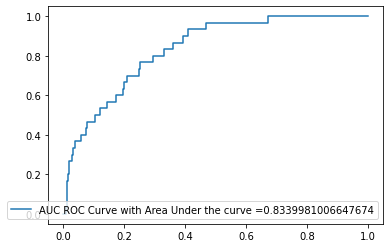

In [ ]:
auc_roc_curve(clf_l, X_test)

In [ ]:
scores(y_test, y_pred_r)

Accuracy =  0.971375807940905
Precision =  0.0
Recall =  0.0
F1 Score =  0.0


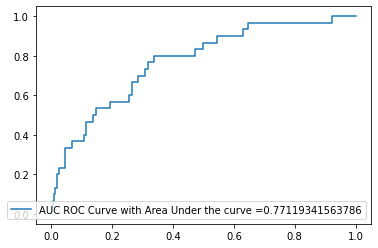

In [ ]:
auc_roc_curve(clf_r, X_test)

In [ ]:
dff

,h500,ivt,qv2m,slp,tpw,uqv,vqv,w500,ex,h500_2,ivt_2,qv2m_2,slm_2,tpw_2,uqv_2,vqv_2,w500_2
date,,,,,,,,,,,,,,,,,
1980-01-03,0.676455,0.973508,0.926271,0.794021,0.929831,0.832833,1.105084,1.067417,0,0.530999,0.908322,0.906029,0.673107,0.849400,0.569867,1.079062,0.965381
1980-01-04,0.740520,0.856347,0.968628,0.800628,0.971815,0.811637,1.060485,1.022756,0,0.676455,0.973508,0.926271,0.794021,0.929831,0.832833,1.105084,1.067417
1980-01-05,0.895034,0.905010,0.934050,1.134577,1.037330,0.905180,1.155132,1.221864,0,0.740520,0.856347,0.968628,0.800628,0.971815,0.811637,1.060485,1.022756
1980-01-06,1.308361,1.063673,0.933331,1.499013,1.091915,1.252556,1.295984,1.303256,0,0.895034,0.905010,0.934050,1.134577,1.037330,0.905180,1.155132,1.221864
1980-01-07,1.273507,0.790399,1.057820,1.484075,0.896990,1.288264,1.095220,1.015022,0,1.308361,1.063673,0.933331,1.499013,1.091915,1.252556,1.295984,1.303256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.745371,0.695266,0.824282,0.685195,0.730762,0.786755,0.758509,0.988913,0,0.807414,0.681451,0.904883,0.577267,0.711015,0.688971,0.989776,0.909792
2019-12-28,0.673514,0.844738,0.860278,0.595738,0.944596,0.826753,0.992366,1.061812,0,0.745371,0.695266,0.824282,0.685195,0.730762,0.786755,0.758509,0.988913
2019-12-29,0.793587,1.026481,0.775458,0.647114,0.881771,0.928708,1.150588,1.106486,0,0.673514,0.844738,0.860278,0.595738,0.944596,0.826753,0.992366,1.061812


# SVM + SMOTE

In [ ]:
oversample = SMOTE(k_neighbors = 7)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [ ]:
unique, count = np.unique(y_train_smote, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{0: 2480, 1: 2480}

kernel = 'linear'

In [ ]:
svc_l = SVC(kernel='linear', probability=True)
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

score = make_scorer(average_precision_score)

clf_l = GridSearchCV(svc_l, parameters, cv=5, scoring=score)
clf_l.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(average_precision_score))

In [ ]:
y_pred_l = clf_l.predict(X_test)

In [ ]:
scores(y_test, y_pred_l)

Accuracy =  0.925207756232687
Precision =  0.1506849315068493
Recall =  0.36666666666666664
F1 Score =  0.21359223300970873


In [ ]:
Accuracy =  0.8337950138504155
Precision =  0.1134020618556701
Recall =  0.7333333333333333
F1 Score =  0.19642857142857142

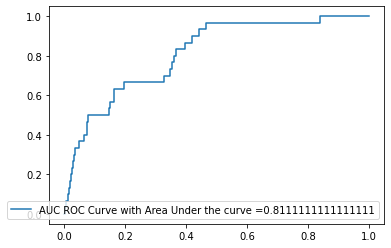

In [ ]:
auc_roc_curve(clf_l, X_test)

In [ ]:
conf(y_test, y_pred_l)

array([[991,  62],
       [ 19,  11]])

In [ ]:
conf(y_test, y_pred_l)

array([[893, 160],
       [ 10,  20]])

kernel = rbf

In [ ]:
svc_r = SVC(kernel='rbf', probability=True)
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

score = make_scorer(average_precision_score)

clf_r = GridSearchCV(svc_r, parameters, cv=5, scoring=score)
clf_r.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(average_precision_score))

In [ ]:
y_pred_r = clf_r.predict(X_test)

In [ ]:
scores(y_test, y_pred_r)

Accuracy =  0.9630655586334257
Precision =  0.2222222222222222
Recall =  0.13333333333333333
F1 Score =  0.16666666666666669


In [ ]:
Accuracy =  0.9353647276084949
Precision =  0.11538461538461539
Recall =  0.2
F1 Score =  0.14634146341463417

SyntaxError: ignored

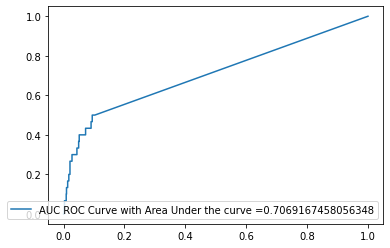

In [ ]:
auc_roc_curve(clf_r, X_test)

In [ ]:
conf(y_test, y_pred_r)

array([[1039,   14],
       [  26,    4]])

# SVM + RandomUndersampling

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_over, y_over = undersample.fit_resample(X_train, y_train)

kernel='rbf'

In [ ]:
svc_r = SVC(kernel='rbf', probability=True)
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

score = make_scorer(average_precision_score)

clf_ru = GridSearchCV(svc_r, parameters, cv=5, scoring=score)
clf_ru.fit(X_over, y_over)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(average_precision_score))

In [ ]:
y_pred_r = clf_ru.predict(X_test)
scores(y_test, y_pred_r)

Accuracy =  0.9012003693444137
Precision =  0.14678899082568808
Recall =  0.5333333333333333
F1 Score =  0.23021582733812954


In [ ]:
Accuracy =  0.7774699907663897
Precision =  0.08300395256916997
Recall =  0.7
F1 Score =  0.14840989399293286

In [ ]:
conf(y_test, y_pred_r)

array([[960,  93],
       [ 14,  16]])

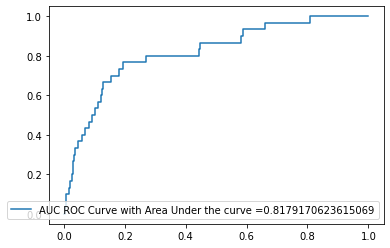

In [ ]:
auc_roc_curve(clf_ru, X_test)

kernel = linear

In [ ]:
svc_l = SVC(kernel='linear', probability=True)
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

score = make_scorer(average_precision_score)

clf_ru = GridSearchCV(svc_l, parameters, cv=5, scoring=score)
clf_ru.fit(X_over, y_over)

GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(average_precision_score))

In [ ]:
y_pred_l = clf_ru.predict(X_test)
scores(y_test, y_pred_l)

Accuracy =  0.8928901200369345
Precision =  0.13559322033898305
Recall =  0.5333333333333333
F1 Score =  0.21621621621621623


In [ ]:
conf(y_test, y_pred_l)

array([[951, 102],
       [ 14,  16]])

# LogReg

In [ ]:
log_reg = LogisticRegression(penalty='l2')
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

score = make_scorer(recall_score)

clf_log = GridSearchCV(log_reg, parameters, cv=5, scoring=score)
clf_log.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(recall_score))

In [ ]:
y_log_pred = clf_log.predict(X_test)

In [ ]:
scores(y_test, y_log_pred)

Accuracy =  0.9695290858725761
Precision =  0.0
Recall =  0.0
F1 Score =  0.0


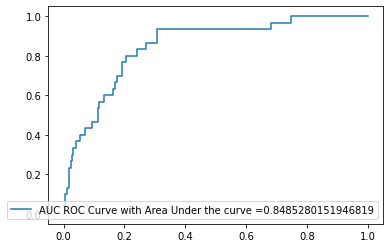

In [ ]:
auc_roc_curve(clf_log, X_test)

# LogReg + SMOTE

In [ ]:
log_reg = LogisticRegression(penalty='l2')
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

score = make_scorer(recall_score)

clf_log = GridSearchCV(log_reg, parameters, cv=5, scoring=score)
clf_log.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(recall_score))

In [ ]:
y_log_pred_sm = clf_log.predict(X_test)

In [ ]:
scores(y_test, y_log_pred_sm)

Accuracy =  0.9353647276084949
Precision =  0.1774193548387097
Recall =  0.36666666666666664
F1 Score =  0.23913043478260868


In [ ]:
Accuracy =  0.8457987072945522
Precision =  0.12154696132596685
Recall =  0.7333333333333333
F1 Score =  0.20853080568720378

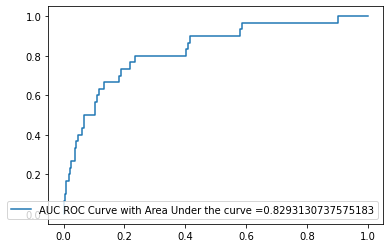

In [ ]:
auc_roc_curve(clf_log, X_test)

In [ ]:
conf(y_test, y_log_pred_sm)

array([[1002,   51],
       [  19,   11]])

# Boosting

In [ ]:
clf = xgb.XGBClassifier()

param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 1],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100, 300, 500],
        'eval_metric': ['aucpr', 'auc']}

fit_params = {'eval_metric': 'mlogloss',
              'early_stopping_rounds': 10}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,
                            scoring='f1',random_state=42)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, eval_metric=aucpr, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=1.0, n_estimators=300, reg_lambda=10.0, silent=False, subsample=1.0; total time=   0.6s
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, eval_metric=aucpr, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=1.0, n_estimators=300, reg_lambda=10.0, silent=False, subsample=1.0; total time=   0.5s
[CV] END colsample_bylevel=0.9, colsample_bytree=1.0, eval_metric=auc, gamma=0, learning_rate=0.001, max_depth=15, min_child_weight=10.0, n_estimators=100, reg_lambda=5.0, silent=False, subsample=0.9; total time=   0.2s
[CV] END colsample_bylevel=0.9, colsample_bytree=1.0, eval_metric=auc, gamma=0, learning_rate=0.001, max_depth=15, min_child_weight=10.0, n_estimators=100, reg_lambda=5.0, silent=False, subsample=0.9; total time=   0.1s
[CV] END colsample_bylevel=1.0, colsa

In [ ]:
y_xg_pred = rs_clf.predict(X_test)

In [ ]:
scores(y_test, y_xg_pred)

Accuracy =  0.9686057248384118
Precision =  0.16666666666666666
Recall =  0.03333333333333333
F1 Score =  0.05555555555555555


In [ ]:
conf(y_test, y_xg_pred)

array([[1048,    5],
       [  29,    1]])

# Boosting + SMOTE

In [ ]:
clf = xgb.XGBClassifier()яя

param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 1],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100, 300, 500],
        'eval_metric': ['aucpr', 'auc']}
rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,
                            scoring='f1',random_state=42)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train_smote, y_train_smote)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, eval_metric=aucpr, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=1.0, n_estimators=300, reg_lambda=10.0, silent=False, subsample=1.0; total time=   1.2s
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, eval_metric=aucpr, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=1.0, n_estimators=300, reg_lambda=10.0, silent=False, subsample=1.0; total time=   1.3s
[CV] END colsample_bylevel=0.9, colsample_bytree=1.0, eval_metric=auc, gamma=0, learning_rate=0.001, max_depth=15, min_child_weight=10.0, n_estimators=100, reg_lambda=5.0, silent=False, subsample=0.9; total time=   0.9s
[CV] END colsample_bylevel=0.9, colsample_bytree=1.0, eval_metric=auc, gamma=0, learning_rate=0.001, max_depth=15, min_child_weight=10.0, n_estimators=100, reg_lambda=5.0, silent=False, subsample=0.9; total time=   1.0s
[CV] END colsample_bylevel=1.0, colsa

In [ ]:
y_xg_pred = rs_clf.predict(X_test)

In [ ]:
scores(y_test, y_xg_pred)

Accuracy =  0.9676823638042474
Precision =  0.2222222222222222
Recall =  0.06666666666666667
F1 Score =  0.10256410256410256


In [ ]:
conf(y_test, y_xg_pred)

array([[1046,    7],
       [  28,    2]])

# Standard Bagging

In [ ]:
model = BaggingClassifier()

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)

In [ ]:
print('Mean Recall: %.3f' % np.mean(scores))

Mean Recall: 0.052


# Standard Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
auc = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('ROC AUC: %.3f' % np.mean(auc))
print('Precision: %.3f' % np.mean(precision))
print('Recall: %.3f' % np.mean(recall))

ROC AUC: 0.711
Precision: 0.233
Recall: 0.048


# Random Forest With Class Weighting

In [ ]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
auc = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('ROC AUC: %.3f' % np.mean(auc))
print('Precision: %.3f' % np.mean(precision))
print('Recall: %.3f' % np.mean(recall))

KeyboardInterrupt: ignored

# Random Forest With Bootstrap Class Weighting

In [ ]:
model = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
auc = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('ROC AUC: %.3f' % np.mean(auc))
print('Precision: %.3f' % np.mean(precision))
print('Recall: %.3f' % np.mean(recall))

ROC AUC: 0.684
Precision: 0.078
Recall: 0.008


# Random Forest With Random Undersampling

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
auc = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('ROC AUC: %.3f' % np.mean(auc))
print('Precision: %.3f' % np.mean(precision))
print('Recall: %.3f' % np.mean(recall))

ROC AUC: 0.828
Precision: 0.072
Recall: 0.748


# Easy Ensemble for Imbalanced Classification

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier
model = EasyEnsembleClassifier(n_estimators=5)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
auc = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('ROC AUC: %.3f' % np.mean(auc))
print('Precision: %.3f' % np.mean(precision))
print('Recall: %.3f' % np.mean(recall))

# RF + Random Oversampling

basic rf

In [ ]:
param_grid = { 
    'n_estimators': [200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
rfc = RandomForestClassifier()
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}


Можно, конечно, увеличить кол-во эстиматоров, но считается долго(

In [ ]:
y_pr1 = CV_rfc.predict(X_test)
#scores(y_test, y_pr1)

In [ ]:
scores(y_test, y_pr1)

TypeError: ignored

In [ ]:
conf(y_test, y_pr1)

array([[1053,    0],
       [  30,    0]])

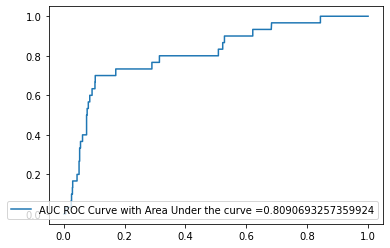

In [ ]:
auc_roc_curve(CV_rfc, X_test)

rf + r/u

In [ ]:
param_grid = { 
    'n_estimators': [200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
rfc = RandomForestClassifier()
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_over, y_over)
print(CV_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}


In [ ]:
y_pr2 = CV_rfc.predict(X_test)
#scores(y_test, y_pr2)

In [ ]:
print("Accuracy = " , accuracy_score(y_test, y_pr2))
print("Precision = " ,precision_score(y_test, y_pr2))
print("Recall = " ,recall_score(y_test, y_pr2))
print("F1 Score = " ,f1_score(y_test, y_pr2))


Accuracy =  0.9067405355493998
Precision =  0.1743119266055046
Recall =  0.6333333333333333
F1 Score =  0.27338129496402874


In [ ]:
conf(y_test, y_pr2)

array([[963,  90],
       [ 11,  19]])